In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

# 1. Pre-Train된 Model 가져오기

In [2]:
pretrained_Model = tf.keras.applications.MobileNetV2(include_top = True, weights='imagenet')
pretrained_Model.trainable=False

# ImageNet 클래스 레이블
decode_predictions=tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 3s 0us/step


# 2. 이미지 전처리
- preprocess Method : MobileNetV2에 맞도록 이미지 전처리 메서드 
- get_imagenet_label Method : 확률벡터에서 레이블 추출하는 헬프 메서드

In [3]:
def preprocess(image):
    image=tf.cast(image,tf.float32)
    image/=255
    image=tf.image.resize(image,(224,224))
    image=image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [4]:
image_path=tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw=tf.io.read_file(image_path)
image=tf.image.decode_image(image_raw)

image=preprocess(image)
image_probs=pretrained_Model.predict(image)

90112/83281 [================================] - 0s 2us/step


# 3. 정상적인 이미지에 대한 Model 출력

40960/35363 [==================================] - 0s 2us/step


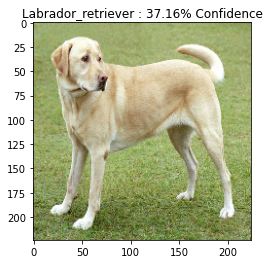

In [5]:
plt.figure()
plt.imshow(image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

# 4. SimBA 알고리즘을 통해 Black-box Adversarial Example 생성

- Q = orthogonal search vector
- Cartesian basis : 입력 이미지와 일치하는 크기의 단위벡터를 Q로 선택
- -> 각 iteration마다 무작위로 one color 픽셀에 e만큼 더하거나 뺌
- 가능한 적은 픽셀의 수가 변하는 것을 목표로 하는 것을 목표로 함 
- Discrete cosine basis : 
- General Basis : 이미지의 크기와 맞게 일치하는 무작위로 생성된 Orthogonal Matrix
- e = step size, Learning rate

In [6]:
from scipy.stats import ortho_group

def simBA(x,Q,e):
    x = preprocess(x)
    x_probs=pretrained_Model.predict(x)
 #   print(x_probs.shape)
    direction_q=[]
    perturbation = np.zeros_like(x[:,:,:,:])
    _, image_class, P = get_imagenet_label(x_probs)
  #  print(perturbation[0].shape)
 
    if Q=='general':
        for i in range(3):
            direction = ortho_group.rvs(dim=x[0].shape[0])
            direction_q.append(np.matmul(direction, direction.T))
    direction_q=np.array(direction_q)
    direction_q=direction_q.reshape((224,224,3))
    for alpha in range(-e,e):
       # print((x[0]+perturbation[0]+alpha*direction_q/100).shape)
        input_image = (x[0]+perturbation[0]+alpha*direction_q/100)
        input_image = np.array(input_image)
        input_image = input_image.reshape((1,224,224,3))
        probs=pretrained_Model.predict(input_image)
        _, classes, P_per = get_imagenet_label(probs)
        if P_per < P:
            perturbation = perturbation+alpha*direction_q
            P = P_per
            break
    return perturbation

In [7]:
pretrained_Model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# 5. Perturbation 생성


In [8]:
image_path=tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw=tf.io.read_file(image_path)
image=tf.image.decode_image(image_raw)

perturbation = simBA(image ,'general', e = 1000)

# 6. Adversarial Example 생성


In [9]:
image_path=tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw=tf.io.read_file(image_path)
image=tf.image.decode_image(image_raw)

image=preprocess(image)
adversarial_example = image+perturbation

In [10]:
adv_probs=pretrained_Model.predict(adversarial_example)

# 7. 정상 이미지와 Adversarial Example의 모델 출력 결과 비교 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Labrador_retriever : 37.16% Confidence')

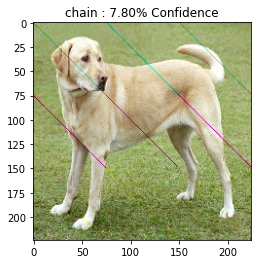

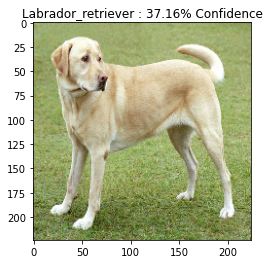

In [11]:
plt.figure()
plt.imshow(adversarial_example[0])
_,adv_class,adv_class_confidence=get_imagenet_label(adv_probs)
plt.title("{} : {:.2f}% Confidence".format(adv_class, adv_class_confidence*100))

plt.figure()
plt.imshow(image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))